In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


D:\Anaconda\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


#BATCH_SIZE = 32
#IMG_SIZE = (160, 160)
#train_dir='Database/Train/'
#validation_dir='Database/Valid/'
#train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            #shuffle=True,
                                                            #batch_size=BATCH_SIZE,
                                                            #image_size=IMG_SIZE)
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                # shuffle=True,
                                                                # batch_size=BATCH_SIZE,
                                                                 #image_size=IMG_SIZE)
#import tensorflow as tf
#AUTOTUNE = tf.data.AUTOTUNE

#train_dataset= train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_datagen = test_datagen.prefetch(buffer_size=AUTOTUNE)
 
batchsize = 10
train_generator=train_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_by_hospital/training_set/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_by_hospital/val_set/',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_by_hospital/test_set/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 311 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


# Model Creation
VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.
Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [4]:
#DENSENET121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#DenseNet169
base_model2=keras.applications.DenseNet169(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)


#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




## setting all layers as non-trainable

In [5]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False

## Defining custom activation function
As per the paper, custom activation function Swish is used in place of Relu in the model.

In [6]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [7]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

## Defining Inception Block:
Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [8]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture
Global Average Pooling
Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [9]:
#DenseNet121
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [10]:
#DenseNet169
x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)

In [11]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [12]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [13]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [14]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [15]:

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_concat (Concatena  (None, 56, 56, 128)  0          ['conv2_block1_concat[0][0]',    
 te)                                                              'conv2_block2_2_conv[0][0]']    
                                                                                                  
 conv2_blo

 conv2_block6_concat (Concatena  (None, 56, 56, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 56, 56, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_relu (Activation)        (None, 56, 56, 256)  0           ['pool2_bn[0][0]']               
                                                                                                  
 pool2_conv (Conv2D)            (None, 56, 56, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 28, 28, 128)  0           ['pool2_conv[0][0]']             
          

                                                                                                  
 conv3_block4_concat (Concatena  (None, 28, 28, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, 28, 28, 256)  0          ['conv3_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block9_0_relu (Activatio  (None, 28, 28, 384)  0          ['conv3_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, 28, 28, 128)  49152       ['conv3_block9_0_relu[0][0]']    
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block9_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block1_0_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 128)  32768       ['conv4_block1_0_relu[0][0]']    
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_concat (Concatena  (None, 14, 14, 416)  0          ['conv4_block4_concat[0][0]',    
 te)                                                              'conv4_block5_2_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block9_concat (Concatena  (None, 14, 14, 544)  0          ['conv4_block8_concat[0][0]',    
 te)                                                              'conv4_block9_2_conv[0][0]']    
                                                                                                  
 conv4_block10_0_bn (BatchNorma  (None, 14, 14, 544)  2176       ['conv4_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv4_block10_0_relu (Activati  (None, 14, 14, 544)  0          ['conv4_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 128)  69632       ['conv4_block10_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 128)  86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block18_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_concat (Concaten  (None, 14, 14, 832)  0          ['conv4_block17_concat[0][0]',   
 ate)                                                             'conv4_block18_2_conv[0][0]']   
                                                                                                  
 conv4_block19_0_bn (BatchNorma  (None, 14, 14, 832)  3328       ['conv4_block18_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_0_relu (Activati  (None, 14, 14, 960)  0          ['conv4_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 128)  122880      ['conv4_block23_0_relu[0][0]']   
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block23_1_conv[0][0]']   
 lization)

 conv4_block27_1_conv (Conv2D)  (None, 14, 14, 128)  139264      ['conv4_block27_0_relu[0][0]']   
                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block31_1_relu[0][0]']   
                                                                                                  
 conv4_block31_concat (Concaten  (None, 14, 14, 1248  0          ['conv4_block30_concat[0][0]',   
 ate)                           )                                 'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, 14, 14, 1248  4992       ['conv4_block31_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block32_0_relu (Activati  (None, 14, 14, 1248  0          ['conv4_block32_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 7, 7, 736)   0           ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 7, 7, 736)   2944        ['conv5_block3_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_block8_0_bn (BatchNormal  (None, 7, 7, 864)   3456        ['conv5_block7_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 7, 7, 864)   0           ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 7, 7, 128)    110592      ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block12_1_conv (Conv2D)  (None, 7, 7, 128)    126976      ['conv5_block12_0_relu[0][0]']   
                                                                                                  
 conv5_block12_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block12_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 7, 7, 1152)  0           ['conv5_block15_concat[0][0]',   
 ate)                                                             'conv5_block16_2_conv[0][0]']   
                                                                                                  
 conv5_block17_0_bn (BatchNorma  (None, 7, 7, 1152)  4608        ['conv5_block16_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block21_0_bn (BatchNorma  (None, 7, 7, 1280)  5120        ['conv5_block20_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block21_0_relu (Activati  (None, 7, 7, 1280)  0           ['conv5_block21_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block21_1_conv (Conv2D)  (None, 7, 7, 128)    163840      ['conv5_block21_0_relu[0][0]']   
                                                                                                  
 conv5_block21_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block21_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block25_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block25_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block25_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block25_1_relu[0][0]']   
                                                                                                  
 conv5_block25_concat (Concaten  (None, 7, 7, 1440)  0           ['conv5_block24_concat[0][0]',   
 ate)     

 conv5_block29_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block29_1_relu[0][0]']   
                                                                                                  
 conv5_block29_concat (Concaten  (None, 7, 7, 1568)  0           ['conv5_block28_concat[0][0]',   
 ate)                                                             'conv5_block29_2_conv[0][0]']   
                                                                                                  
 conv5_block30_0_bn (BatchNorma  (None, 7, 7, 1568)  6272        ['conv5_block29_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block30_0_relu (Activati  (None, 7, 7, 1568)  0           ['conv5_block30_0_bn[0][0]']     
 on)                                                                                              
          

 batch_normalization_111 (Batch  (None, 7, 7, 512)   2048        ['lambda_17[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 512)   2048        ['lambda_20[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 7, 7, 512)   0           ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 512)    262656      ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_11

 batch_normalization_119 (Batch  (None, 7, 7, 512)   2048        ['lambda_25[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_122 (Batch  (None, 7, 7, 512)   2048        ['lambda_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_123 (Batch  (None, 7, 7, 512)   2048        ['lambda_29[0][0]']              
 Normalization)                                                                                   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Compiling the Model 

In [16]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['DenseNet169','DenseNet121','VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='DenseNet121':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='DenseNet169':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])

        
if __name__ == "__main__":
    comp()

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training the Models

### 1.DenseNet-121

In [17]:
#DenseNet121
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 27s 415ms/step - loss: 0.6157 - accuracy: 0.6431 - mse: 0.2134 - val_loss: 0.6699 - val_accuracy: 0.6190 - val_mse: 0.2384
Epoch 2/50
31/31 [==============================] - 9s 276ms/step - loss: 0.4839 - accuracy: 0.7846 - mse: 0.1570 - val_loss: 0.6646 - val_accuracy: 0.6190 - val_mse: 0.2359
Epoch 3/50
31/31 [==============================] - 8s 265ms/step - loss: 0.4450 - accuracy: 0.7685 - mse: 0.1448 - val_loss: 0.6628 - val_accuracy: 0.6190 - val_mse: 0.2350
Epoch 4/50
31/31 [==============================] - 8s 263ms/step - loss: 0.4064 - accuracy: 0.8328 - mse: 0.1283 - val_loss: 0.6617 - val_accuracy: 0.6190 - val_mse: 0.2345
Epoch 5/50
31/31 [==============================] - 8s 264ms/step - loss: 0.3479 - accuracy: 0.8424 - mse: 0.1079 - val_loss: 0.6597 - val_accuracy: 0.6190 - val_mse: 0.2336
Epoch 6/50
31/31 [==============================] - 8s 264ms/step - loss: 0.3478 - accuracy: 0.8328 - mse: 0.1086 - val_loss: 0.6

Epoch 48/50
31/31 [==============================] - 8s 262ms/step - loss: 0.0969 - accuracy: 0.9871 - mse: 0.0197 - val_loss: 0.2986 - val_accuracy: 0.8831 - val_mse: 0.0812
Epoch 49/50
31/31 [==============================] - 8s 262ms/step - loss: 0.0998 - accuracy: 0.9775 - mse: 0.0223 - val_loss: 0.2869 - val_accuracy: 0.8874 - val_mse: 0.0780
Epoch 50/50
31/31 [==============================] - 8s 263ms/step - loss: 0.1138 - accuracy: 0.9678 - mse: 0.0276 - val_loss: 0.2922 - val_accuracy: 0.8788 - val_mse: 0.0798
Execution Time :  433.56852316856384


In [19]:
model1.save('SavedModels/RIM ONE/D121.h5')

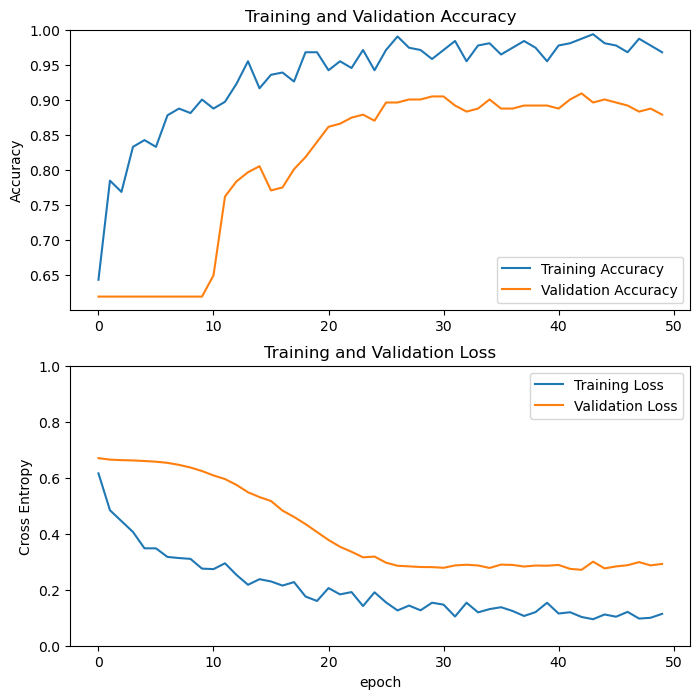

In [20]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

17/17 [==============================] - 3s 178ms/step - loss: 0.6279 - accuracy: 0.7069 - mse: 0.1908
['loss', 'accuracy', 'mse']
[0.6279321908950806, 0.7068965435028076, 0.19076025485992432]
testing time : 3.380723476409912


In [22]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 4s 120ms/step
Confusion Matrix
[[38 18]
 [33 85]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.54      0.68      0.60        56
      Normal       0.83      0.72      0.77       118

    accuracy                           0.71       174
   macro avg       0.68      0.70      0.68       174
weighted avg       0.73      0.71      0.71       174



In [23]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

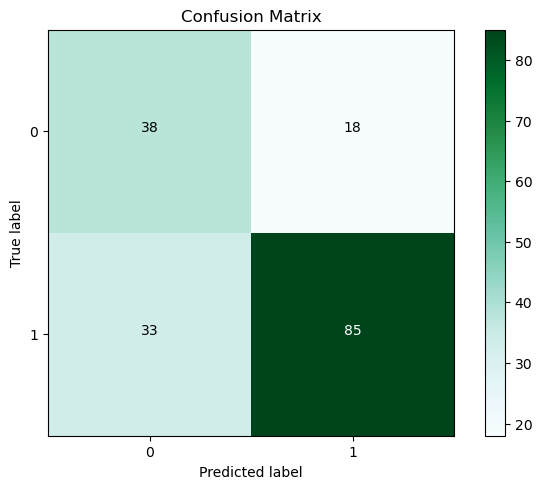

In [24]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### DenseNet-169

In [25]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 22s 432ms/step - loss: 0.6436 - accuracy: 0.6559 - mse: 0.2236 - val_loss: 0.7126 - val_accuracy: 0.3810 - val_mse: 0.2597
Epoch 2/50
31/31 [==============================] - 10s 317ms/step - loss: 0.4948 - accuracy: 0.7588 - mse: 0.1620 - val_loss: 0.7262 - val_accuracy: 0.3810 - val_mse: 0.2665
Epoch 3/50
31/31 [==============================] - 10s 310ms/step - loss: 0.4290 - accuracy: 0.8167 - mse: 0.1366 - val_loss: 0.7386 - val_accuracy: 0.3810 - val_mse: 0.2725
Epoch 4/50
31/31 [==============================] - 10s 317ms/step - loss: 0.4203 - accuracy: 0.7974 - mse: 0.1334 - val_loss: 0.7461 - val_accuracy: 0.3810 - val_mse: 0.2762
Epoch 5/50
31/31 [==============================] - 10s 315ms/step - loss: 0.3978 - accuracy: 0.8199 - mse: 0.1241 - val_loss: 0.7406 - val_accuracy: 0.3810 - val_mse: 0.2735
Epoch 6/50
31/31 [==============================] - 10s 309ms/step - loss: 0.3383 - accuracy: 0.8682 - mse: 0.1014 - val_loss

Epoch 48/50
31/31 [==============================] - 9s 305ms/step - loss: 0.1026 - accuracy: 0.9839 - mse: 0.0213 - val_loss: 0.1797 - val_accuracy: 0.9264 - val_mse: 0.0553
Epoch 49/50
31/31 [==============================] - 9s 305ms/step - loss: 0.1032 - accuracy: 0.9807 - mse: 0.0220 - val_loss: 0.1915 - val_accuracy: 0.9177 - val_mse: 0.0590
Epoch 50/50
31/31 [==============================] - 9s 305ms/step - loss: 0.1159 - accuracy: 0.9743 - mse: 0.0273 - val_loss: 0.2116 - val_accuracy: 0.9048 - val_mse: 0.0667
Execution Time :  487.6888918876648


In [26]:

model2.save('SavedModels/RIM ONE/D169.h5')

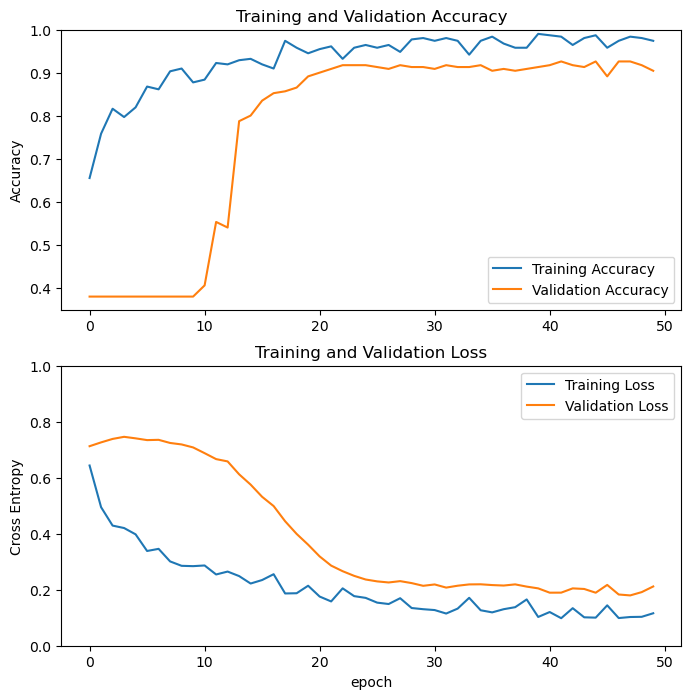

In [27]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

17/17 [==============================] - 3s 141ms/step - loss: 0.6602 - accuracy: 0.7011 - mse: 0.2125
['loss', 'accuracy', 'mse']
[0.6601731777191162, 0.7011494040489197, 0.21254971623420715]
testing time : 2.809392213821411


In [29]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 5s 148ms/step
Confusion Matrix
[[42 14]
 [38 80]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.53      0.75      0.62        56
      Normal       0.85      0.68      0.75       118

    accuracy                           0.70       174
   macro avg       0.69      0.71      0.69       174
weighted avg       0.75      0.70      0.71       174



Text(0.5, 23.52222222222222, 'Predicted label')

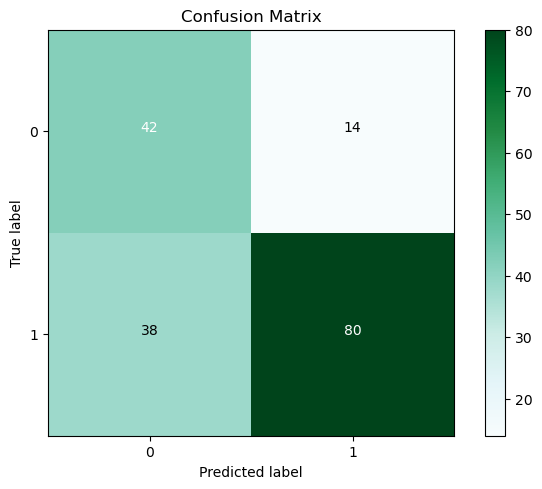

In [30]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3. VGG-19

In [17]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 22s 420ms/step - loss: 0.6433 - accuracy: 0.6174 - mse: 0.2263 - val_loss: 0.6753 - val_accuracy: 0.6190 - val_mse: 0.2411
Epoch 2/50
31/31 [==============================] - 12s 379ms/step - loss: 0.5528 - accuracy: 0.7395 - mse: 0.1848 - val_loss: 0.6668 - val_accuracy: 0.6190 - val_mse: 0.2369
Epoch 3/50
31/31 [==============================] - 12s 381ms/step - loss: 0.5218 - accuracy: 0.7556 - mse: 0.1712 - val_loss: 0.6602 - val_accuracy: 0.6190 - val_mse: 0.2338
Epoch 4/50
31/31 [==============================] - 12s 380ms/step - loss: 0.4929 - accuracy: 0.7814 - mse: 0.1595 - val_loss: 0.6565 - val_accuracy: 0.6190 - val_mse: 0.2321
Epoch 5/50
31/31 [==============================] - 12s 382ms/step - loss: 0.4751 - accuracy: 0.8103 - mse: 0.1520 - val_loss: 0.6533 - val_accuracy: 0.6190 - val_mse: 0.2307
Epoch 6/50
31/31 [==============================] - 12s 379ms/step - loss: 0.4390 - accuracy: 0.8264 - mse: 0.1366 - val_loss

In [18]:
model3.save('SavedModels/RIM ONE/VGG19.h5')

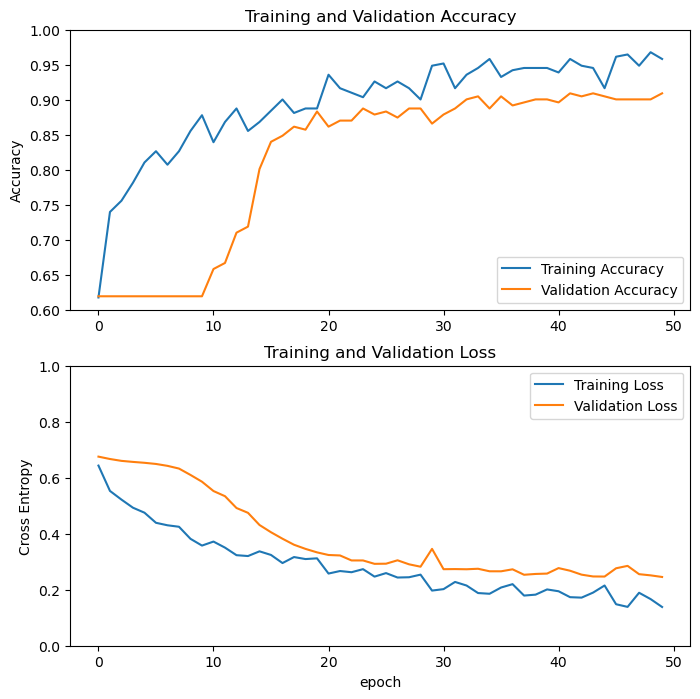

In [19]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

17/17 [==============================] - 5s 258ms/step - loss: 0.5384 - accuracy: 0.7644 - mse: 0.1682
['loss', 'accuracy', 'mse']
[0.5383681058883667, 0.7643678188323975, 0.16816169023513794]
testing time : 4.824245929718018


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 3s 175ms/step
Confusion Matrix
[[41 15]
 [26 92]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.61      0.73      0.67        56
      Normal       0.86      0.78      0.82       118

    accuracy                           0.76       174
   macro avg       0.74      0.76      0.74       174
weighted avg       0.78      0.76      0.77       174



Text(0.5, 23.52222222222222, 'Predicted label')

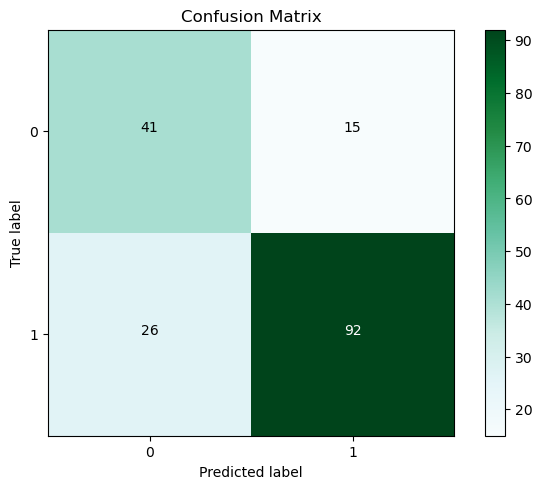

In [22]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4. MobileNet V2

In [23]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 10s 192ms/step - loss: 0.6469 - accuracy: 0.6270 - mse: 0.2281 - val_loss: 0.6743 - val_accuracy: 0.5628 - val_mse: 0.2409
Epoch 2/50
31/31 [==============================] - 5s 148ms/step - loss: 0.5021 - accuracy: 0.7556 - mse: 0.1653 - val_loss: 0.5960 - val_accuracy: 0.7359 - val_mse: 0.2030
Epoch 3/50
31/31 [==============================] - 5s 146ms/step - loss: 0.4409 - accuracy: 0.8328 - mse: 0.1394 - val_loss: 0.5500 - val_accuracy: 0.7706 - val_mse: 0.1821
Epoch 4/50
31/31 [==============================] - 5s 148ms/step - loss: 0.3734 - accuracy: 0.8714 - mse: 0.1133 - val_loss: 0.5033 - val_accuracy: 0.7835 - val_mse: 0.1627
Epoch 5/50
31/31 [==============================] - 4s 144ms/step - loss: 0.3345 - accuracy: 0.8489 - mse: 0.1002 - val_loss: 0.4654 - val_accuracy: 0.8095 - val_mse: 0.1471
Epoch 6/50
31/31 [==============================] - 5s 147ms/step - loss: 0.2920 - accuracy: 0.9196 - mse: 0.0814 - val_loss: 0.4

Epoch 48/50
31/31 [==============================] - 4s 144ms/step - loss: 0.0512 - accuracy: 0.9968 - mse: 0.0079 - val_loss: 0.3333 - val_accuracy: 0.9091 - val_mse: 0.0790
Epoch 49/50
31/31 [==============================] - 4s 144ms/step - loss: 0.0537 - accuracy: 0.9968 - mse: 0.0081 - val_loss: 0.3363 - val_accuracy: 0.9091 - val_mse: 0.0796
Epoch 50/50
31/31 [==============================] - 5s 146ms/step - loss: 0.0679 - accuracy: 0.9775 - mse: 0.0153 - val_loss: 0.3384 - val_accuracy: 0.9091 - val_mse: 0.0796
Execution Time :  233.63853931427002


In [24]:
model4.save('SavedModels/RIM ONE/MobileNet.h5')

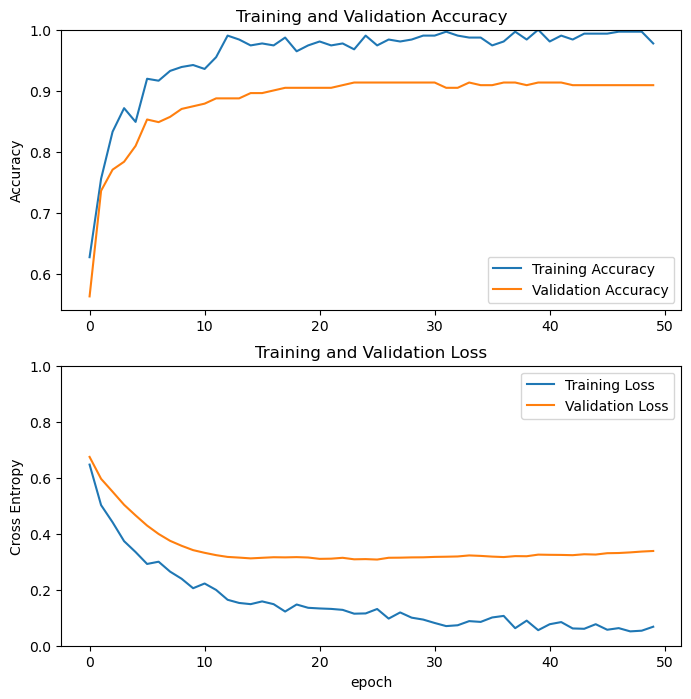

In [25]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

17/17 [==============================] - 2s 84ms/step - loss: 0.7081 - accuracy: 0.7586 - mse: 0.1902
['loss', 'accuracy', 'mse']
[0.7081477046012878, 0.7586206793785095, 0.19015257060527802]
testing time : 1.9005088806152344


In [27]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 2s 78ms/step
Confusion Matrix
[[34 22]
 [20 98]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.63      0.61      0.62        56
      Normal       0.82      0.83      0.82       118

    accuracy                           0.76       174
   macro avg       0.72      0.72      0.72       174
weighted avg       0.76      0.76      0.76       174



Text(0.5, 23.52222222222222, 'Predicted label')

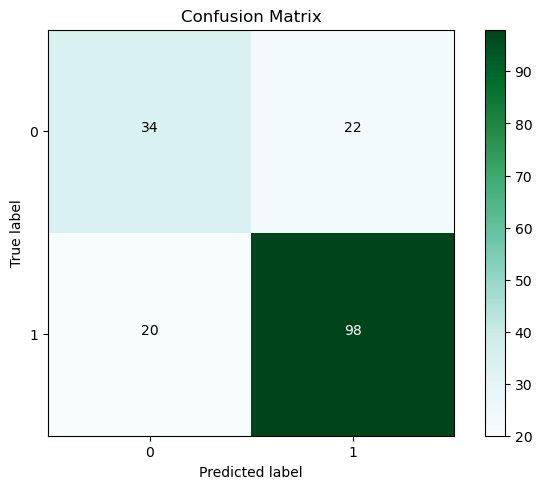

In [28]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ResNet50

In [29]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 17s 405ms/step - loss: 0.6823 - accuracy: 0.7492 - mse: 0.2446 - val_loss: 0.7536 - val_accuracy: 0.3810 - val_mse: 0.2799
Epoch 2/50
31/31 [==============================] - 11s 349ms/step - loss: 0.6733 - accuracy: 0.7556 - mse: 0.2401 - val_loss: 0.8734 - val_accuracy: 0.3810 - val_mse: 0.3343
Epoch 3/50
31/31 [==============================] - 11s 348ms/step - loss: 0.6663 - accuracy: 0.7588 - mse: 0.2366 - val_loss: 1.0313 - val_accuracy: 0.3810 - val_mse: 0.3948
Epoch 4/50
31/31 [==============================] - 11s 352ms/step - loss: 0.6570 - accuracy: 0.7878 - mse: 0.2320 - val_loss: 1.2149 - val_accuracy: 0.3810 - val_mse: 0.4503
Epoch 5/50
31/31 [==============================] - 11s 348ms/step - loss: 0.6493 - accuracy: 0.8167 - mse: 0.2282 - val_loss: 1.4003 - val_accuracy: 0.3810 - val_mse: 0.4929
Epoch 6/50
31/31 [==============================] - 11s 348ms/step - loss: 0.6427 - accuracy: 0.8167 - mse: 0.2249 - val_loss

In [30]:
model5.save('SavedModels/RIM ONE/ResNet.h5')

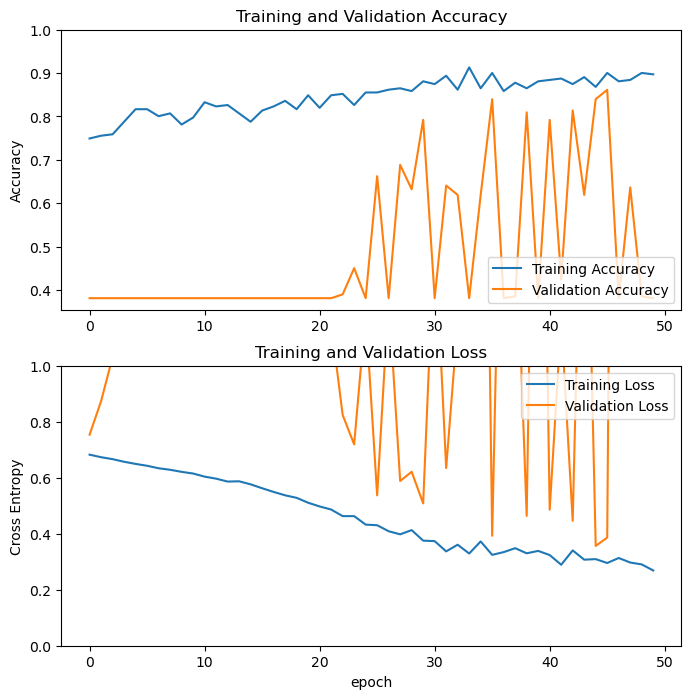

In [31]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

17/17 [==============================] - 4s 191ms/step - loss: 4.6279 - accuracy: 0.3218 - mse: 0.6744
['loss', 'accuracy', 'mse']
[4.627863883972168, 0.3218390941619873, 0.674446702003479]
testing time : 3.7776331901550293


In [33]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 4s 157ms/step
Confusion Matrix
[[ 56   0]
 [118   0]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.32      1.00      0.49        56
      Normal       0.00      0.00      0.00       118

    accuracy                           0.32       174
   macro avg       0.16      0.50      0.24       174
weighted avg       0.10      0.32      0.16       174



D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 23.52222222222222, 'Predicted label')

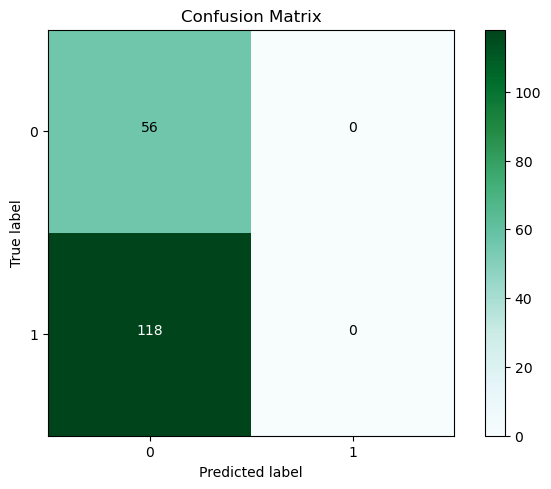

In [34]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6. Inception V3

In [35]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
31/31 [==============================] - 16s 328ms/step - loss: 0.6766 - accuracy: 0.5884 - mse: 0.2414 - val_loss: 0.6473 - val_accuracy: 0.6104 - val_mse: 0.2279
Epoch 2/50
31/31 [==============================] - 7s 239ms/step - loss: 0.4603 - accuracy: 0.7588 - mse: 0.1523 - val_loss: 0.6153 - val_accuracy: 0.6320 - val_mse: 0.2131
Epoch 3/50
31/31 [==============================] - 7s 239ms/step - loss: 0.4152 - accuracy: 0.8232 - mse: 0.1306 - val_loss: 0.5866 - val_accuracy: 0.6623 - val_mse: 0.2001
Epoch 4/50
31/31 [==============================] - 7s 240ms/step - loss: 0.2986 - accuracy: 0.9068 - mse: 0.0839 - val_loss: 0.5465 - val_accuracy: 0.7100 - val_mse: 0.1831
Epoch 5/50
31/31 [==============================] - 7s 239ms/step - loss: 0.3089 - accuracy: 0.8875 - mse: 0.0885 - val_loss: 0.5089 - val_accuracy: 0.7446 - val_mse: 0.1673
Epoch 6/50
31/31 [==============================] - 7s 238ms/step - loss: 0.2354 - accuracy: 0.9550 - mse: 0.0593 - val_loss: 0.4

Epoch 48/50
31/31 [==============================] - 7s 238ms/step - loss: 0.0625 - accuracy: 0.9807 - mse: 0.0143 - val_loss: 0.5174 - val_accuracy: 0.8398 - val_mse: 0.1216
Epoch 49/50
31/31 [==============================] - 7s 240ms/step - loss: 0.0451 - accuracy: 1.0000 - mse: 0.0056 - val_loss: 0.5171 - val_accuracy: 0.8398 - val_mse: 0.1202
Epoch 50/50
31/31 [==============================] - 7s 238ms/step - loss: 0.0440 - accuracy: 1.0000 - mse: 0.0069 - val_loss: 0.5256 - val_accuracy: 0.8485 - val_mse: 0.1202
Execution Time :  380.681521654129


In [36]:
model6.save('SavedModels/RIM ONE/Inception.h5')

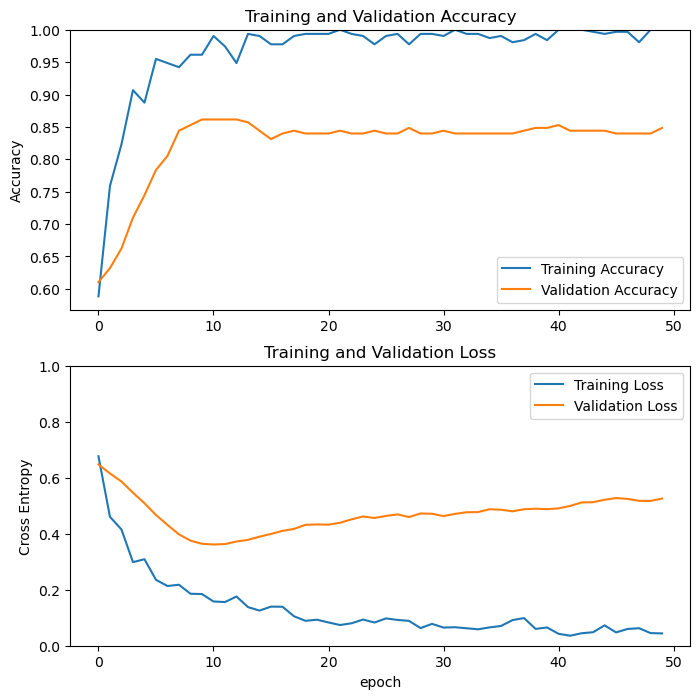

In [37]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

17/17 [==============================] - 4s 195ms/step - loss: 1.0508 - accuracy: 0.6667 - mse: 0.2622
['loss', 'accuracy', 'mse']
[1.0508030652999878, 0.6666666865348816, 0.2621617913246155]
testing time : 3.690105676651001


In [39]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 3s 101ms/step
Confusion Matrix
[[40 16]
 [42 76]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.49      0.71      0.58        56
      Normal       0.83      0.64      0.72       118

    accuracy                           0.67       174
   macro avg       0.66      0.68      0.65       174
weighted avg       0.72      0.67      0.68       174



Text(0.5, 23.52222222222222, 'Predicted label')

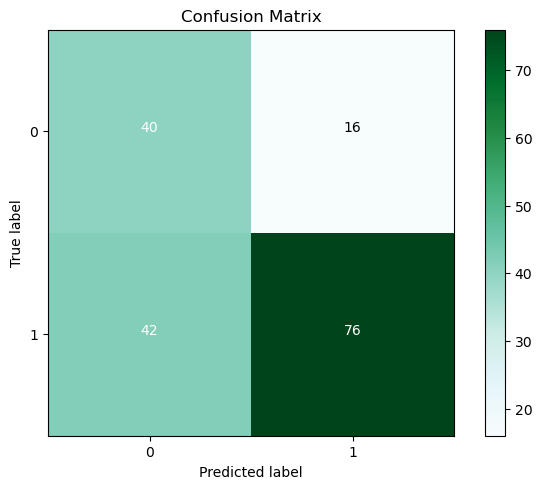

In [40]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')